# ENGR 76 Project 1d—Color space transformation and subsampling

_Due: Friday, May 06, 2022 at 12:00 PM_

<font color='blue'>**YOUR STANFORD EMAIL:**</font>     clpondoc@stanford.edu

This is one of the options for Project 1d. See the overview handout, “Exploring ideas in lossy image compression”, for the others.


In this project, you will:
- Investigate how color space transformation and subsampling can help further lossily compress an image.
- Incorporate this new compression tool into your image compressor from Project 1c.

You can think of this project as a continuation of Project 1c, so the same general guidelines apply.

<!--Since we'll be exploring lots of different elements of image compression, most of the evaluation will come first. You'll need to write a few functions along the way, but they'll be short (unlike in Project 1a). -->

<div class="alert alert-info" style="color:black;">
    <p>
        <strong>Where we are in Project 1.</strong> This week, we'll add the final layer to our compressor--color space transformation and subsampling--which makes images more amenable to compression.  
    </p>
    <p style="text-align: center;">
        <img src="img/proj1d-where.png" style="height: 85px;" />
    </p>
</div>

<div class="alert alert-info" style="color:black;">
You might find some of these <a href="https://canvas.stanford.edu/courses/154344/files/folder/Project%201d?preview=9753070">"Python Snippets"</a> to be helpful for this assignment. You can also find them in the <a href="https://canvas.stanford.edu/courses/154344/files/folder/Project%201d?">Project 1d Folder on Canvas.</a> 
</div


## General notes

- Where we provide example code, you are permitted to copy it. You are also permitted and encouraged to modify / play around with the example code to help gain understanding. It won't matter to us if the examples we provide aren't present in the notebook you submit—we'll only look at answers to our questions.
- As always, you're welcome and encouraged to discuss ideas in this project with your classmates. And as always, you should not directly share code.
- Where we want written answers, they're marked with an "YOUR ANSWER HERE" block. Please **keep the `>` sign** before your answers — it makes it easier for us to find them.

# Summary table

Here is a table that you will be asked to fill out as you work through this assignment: 

> |Question | Description / Parameters                 | Compression ratio    |  Mean squared error       |
>  |---------|----------------------------------|------------------------------------|-------|
>  |   1.4   |   # quantization levels: 1500,  cutoff frequency proportion: (1/3, 1/3)               |         0.0413                           |  34.54 |
>  |   1.5   |    # quantization levels: 1500,  cutoff frequency proportion: (1/3, 1/3)                |  0.0334                             |  43.60 |
>  |   1.6   |   # quantization levels: 1500,  cutoff frequency proportion: (1/3, 1/3)                 |    0.0311                             | 36.71  |
>  |   2.1, sampling Y    |   # quantization levels: 1500,  cutoff frequency proportion: (1/3, 1/3), sampling rate: 1                 |  0.0747                            |   32.61 |
>  |   2.1, sampling Cb   |   # quantization levels: 1500,  cutoff frequency proportion: (1/3, 1/3), sampling rate: 5                |   0.05187                              |   36.165 |
>  |   2.1, sampling Cr    |   # quantization levels: 1500,  cutoff frequency proportion: (1/3, 1/3), sampling rate: 5                |    0.05175                           |   38.049 |

# Part1: Color space transformation

In the arrays we’ve been working with so far, a color (of a pixel) is represented as three numbers, representing the amount of red, green and blue light that you would add together to reproduce the color to the human eye. For example, if 8-bit integers (ranging from 0 to 255) are used for each component, then we can represent colors like in the following examples:

<br>
<center><img src="img/color-space.png" style="height: 170px;"></center>
<br>

A convention for representing colors numerically is called a _color model_ or a _color space_. The above color model, known as RGB, is commonly used in computers and electronics because it reflects how LCD screens produce colors—they vary the amount of red, green and blue light emitted by each pixel. But in other contexts, other models can be more appropriate.

We’ll study another color model, YCbCr, that is often used in image compression. The process of converting from one color model to another is called a _color space transformation_ or _conversion_. The conversion from $(R,G,B)$ to $(Y, C_B, C_R)$ is defined as follows:

$$ Y = K_RR+K_GG+K_BB $$
$$ C_B = \frac{1}{2}\cdot \frac{B-Y}{1-K_B}$$
$$ C_R = \frac{1}{2}\cdot \frac{R-Y}{1-K_R}$$

where $K_R, K_G, K_B$ are positive constants satisfying $K_R + K_G + K_B = 1$.

## 1.1) Getting to know the YCbCr space

<span style="background-color: #8C1515; font-weight: bold; color: white;">Question 1.1.</span> 
If $K_R = K_G = K_B = \frac{1}{3} $ , then what does $Y$ represent about the color of a pixel? If you transformed an image to YCbCr, discarded the $C_B$ and $C_R$ components (by setting them to zero in the above equations) and transformed back to RGB, what would the resulting image look like? Explain your answer in terms of the equations above.

_Remark: When working with these formulae mathematically, some people find it more intuitive to think of $R, G, B$ as being on a scale from 0 to 1 (so white would be $(1, 1, 1)$). However, in 8-bit computer representations, values run from 0 to 255, so this is the range that we’ll use._

> Note that Y is the Luma component, which represents the brightness of the color. Thus, if $K_R = K_G = K_B = \frac{1}{3}$, then the YCbCr image will be $\frac{1}{3}$ of the total amount of intensity in the original RGB image. Similarly, if we discarded the $C_B$ and $C_R$ components by setting them equal to $0$, then we know that $B = Y$ and $R = Y$, so $B = Y = R$. Thus, we see that the resulting image would be some shade of white to black, depending on the value of $Y$. 

----
<span style="background-color: #8C1515; font-weight: bold; color: white;">Question 1.2.</span> 
If $R, G, B$ can vary from 0 to 255, according to the formulae above, what are the minimum and maximum values that $Y$ , $C_B$ and $C_R$ could possibly take?

_Hint: You should find that it doesn’t depend on $K_R, K_G, K_B$—that is, all valid choices of those constants will give the same range._

> If $R, G, B$ can vary from $0$ to $255$, then we see that $Y$ ranges from $[0, 255]$ and both $C_B$ and $C_R$ rage from $[-122.5,122.5]$.

## 1.2) Applying the color space transformation

In the context of 8-bit integers, we add 128 (the middle of the 8-bit integer range) to the $C_B$ and $C_R$ components:

$$ Y = K_RR+K_GG+K_BB $$
$$ C_B = \frac{1}{2}\cdot \frac{B-Y}{1-K_B}+128$$
$$ C_R = \frac{1}{2}\cdot \frac{R-Y}{1-K_R}+128$$

We’ve provided functions below that apply this transformation, and its inverse transformation (going from YCbCr to RGB), on a 3-D array representing a color image. (These functions also take care of data type conversions, so that the input and output are both 8-bit integers, or `uint8`s.)


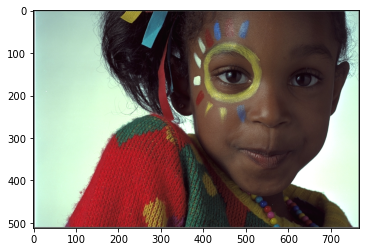

In [1]:
import imageio
import numpy as np
import scipy.fft
import matplotlib.pyplot as plt
import pickle
from compressor import huffman_compress, huffman_decompress

# Reminder: This is how you open and display an image
original = imageio.imread('img/girl.png')
plt.imshow(original)
plt.show()

In [2]:
# Helper functions for color space transformation
# Default values of Kr, Kg, Kb are the constants used in questions 1.3 and 1.5.

def rgb_to_ycbcr(A, Kr=1/3, Kg=1/3, Kb=1/3):
    """Transforms the RGB image `A` to YCbCr.
    Constants Kr, Kg, Kb must be defined outside this function.
    `A` must be a 3-D array with third axis size 3."""
    R, G, B = A.transpose(2, 0, 1)
    Y = Kr * R + Kg * G + Kb * B
    Cb = (B - Y) / (2 * (1 - Kb)) + 128
    Cr = (R - Y) / (2 * (1 - Kr)) + 128
    return np.dstack((Y, Cb, Cr)).clip(0, 255).round().astype('uint8')

def ycbcr_to_rgb(A, Kr=1/3, Kg=1/3, Kb=1/3):
    """Transforms the YCbCr image `A` to RGB.
    Constants Kr, Kg, Kb must be defined outside this function.
    `A` must be a 3-D array with third axis size 3."""
    A = A.astype('float')
    Y, Cb, Cr = A.transpose(2, 0, 1)
    R = Y + 2 * (1 - Kr) * (Cr - 128)
    B = Y + 2 * (1 - Kb) * (Cb - 128)
    G = (Y - Kr * R - Kb * B) / Kg
    return np.dstack((R, G, B)).clip(0, 255).round().astype('uint8')

----
<span style="background-color: #8C1515; font-weight: bold; color: white;">Question 1.3.</span> 

Try “isolating” each of the $Y$ , $C_B$ and $C_R$ components of **your sample image from Project 1c**, producing three images with only one component each, to see what they each look like.

_Remark: Because we’re dealing with 8-bit integers, the transformation functions we provide in the starter file add 128 to the $C_B$ and $C_R$ components. So to “remove” those components, you should set them to 128 (not 0). You’ll find that when removing the $Y$ component, the visualization is better if you set it to 128 as well._

To “isolate” a component: (1) transform it to $(Y, C_B, C_R)$, (2) set the components you’re removing to 128, then (3) transform it back to $(R, G, B)$. Show your original image and each of your three component images side by side (using `imshow_side_by_side(img1, img2, img3)`) in the cell below .

_Hint: Python snippets (a) and (b) might be useful for this part. Also, use `np.zeros(s, d)` to create an all-zeros array of shape `s` with datatype `d` (e.g., `np.uint8`)._

**Throughout this notebook, please use the same sample image you used in Project 1c.**

In [3]:
# If you want to display images side by side, you can use this. 
# Feel free to adjust figsize to suit your screen and images:
def imshow_side_by_side(*imgs, figsize=(18, 5)):
    num_imgs = len(imgs)
    fig, axs = plt.subplots(1, num_imgs, figsize=figsize)
    for i in range(num_imgs):
        axs[i].imshow(imgs[i])


## Question 1.3 Helper Functions
Helper functions used to create the components and isolate each of them.

In [4]:
# Create separate components
def create_components(image):
    ycbcr_girl = rgb_to_ycbcr(original)
    Y = ycbcr_girl[:, :, 0]
    Cb = ycbcr_girl[:, :, 1]
    Cr = ycbcr_girl[:, :, 2]
    return [Y, Cb, Cr]

def isolate_components(image):
    components = create_components(image)
    for i in range(len(components)):
        for j in range(len(components)):
            if (i != j):
                components[j][:] = 128
        edited_image = np.dstack((components[0], components[1], components[2]))
        converted_image = ycbcr_to_rgb(edited_image)
        imshow_side_by_side(original, converted_image)
        components = create_components(image)


## Question 1.2 Implementation
Calling the above helper functions!

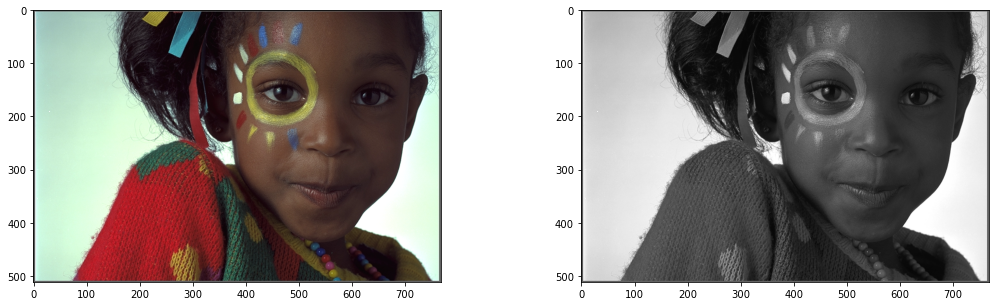

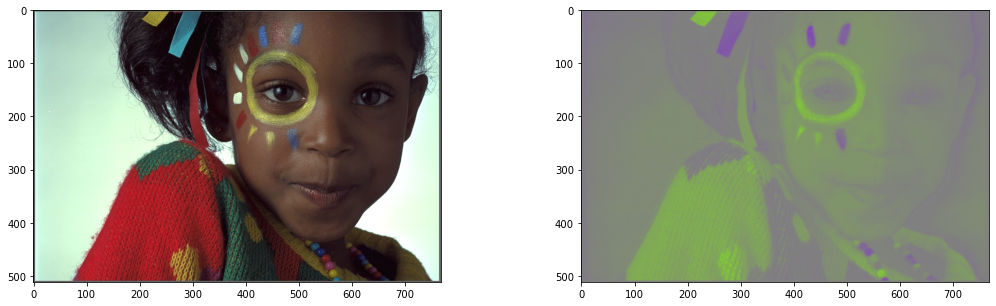

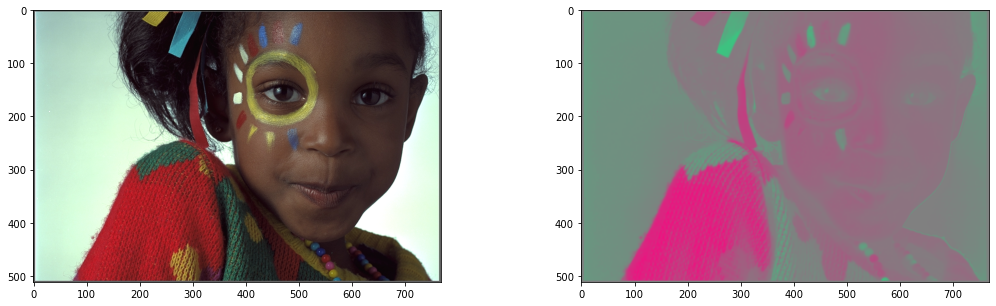

In [5]:
# Question 1.3. -- Calling helper functions!
isolate_components(original)

----
<span style="background-color: #8C1515; font-weight: bold; color: white;">Question 1.4.</span> 

Report the final compression ratio and mean squared error you obtained in Project 1c (for the same sample image as above). Also copy the numbers (and the parameters you used) to the table in Part 1. 

(There's no actual work for this question--just copying over your results from Project 1c.)

> From Project 1c, the final compression ratio is  0.0413 while the mean square error is 34.54.

----
<span style="background-color: #8C1515; font-weight: bold; color: white;">Question 1.5.</span> 

Using the constants $K_R = K_G = K_B = \frac{1}{3}$ (which are the default values provided in the helper functions) apply the following steps to your sample image:

- Transform the image to YCbCr space.
- Apply all of the steps from Project 1c: DCT, filter, quantize, Huffman.

As usual, reverse the steps to decompress and recover the image. Display the original and the recovered images side by side (using `imshow_side_by_side()`) and report the compression ratio and mean squared error. Copy the numbers to the table in Part 1.

In [6]:
# DCT functions from Project 1b

def dctim(A):
    """Returns the 2-D discrete cosine transform of the image `A`."""
    A = A.astype('float')
    return scipy.fft.dct(
        scipy.fft.dct(A - 128, axis=0, type=2, norm="ortho"),
        axis=1, type=2, norm="ortho")

def idctim(F):
    """Returns the 2-D inverse discrete cosine transform of the array `F`,
    shifted to the 8-bit range of an image."""
    A = scipy.fft.idct(
        scipy.fft.idct(F, axis=0, type=2, norm="ortho"),
        axis=1, type=2, norm="ortho") + 128
    return A.clip(0, 255).round().astype('uint8')


def lopass_spectrum(F, fcx, fcy):
    """Returns just the low-pass part of the given spectrum,
    reshaped into a vector."""
    return F[:fcx, :fcy].reshape((-1,))

def inflate_spectrum(F, fcx, fcy, shape):
    """Returns the zero-padded spectrum of size `shape`, inserting entries
    of `F` into the `[:fcx, :fcy]` entries."""
    spectrum = np.zeros(shape)
    spectrum[:fcx, :fcy] = F.reshape((fcx, fcy, -1))
    return spectrum

# Quantize functions from Project 1c

def quantize(A, nlevels):
    smallest = np.min(A)
    largest = np.max(A)
    bins = np.linspace(smallest, largest, nlevels+1)
    bins[-1] = np.nextafter(bins[-1], np.infty)
    bin_indices = np.digitize(A, bins)
    limits = (smallest, largest)
    return bin_indices, limits

def dequantize(bin_indices, nlevels, limits):
    smallest, largest = limits
    bins = np.linspace(smallest, largest, nlevels+1)
    vals = (bins[1:]+bins[:-1]) / 2
    reconstructed = vals[bin_indices-1]
    return reconstructed

Actual compression ratio: 0.033440483940972224
Mean Squared Error: 43.602203369140625


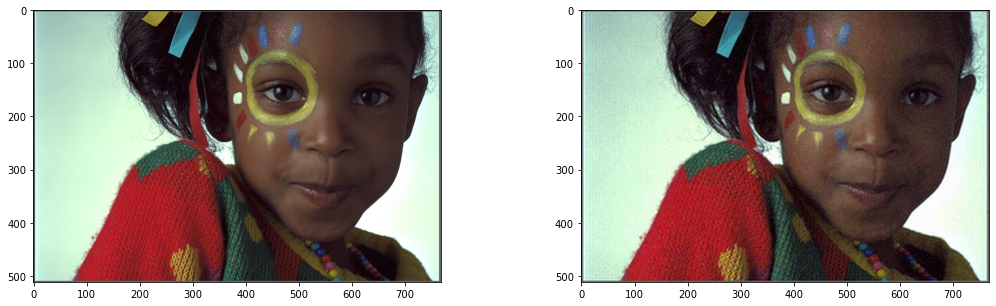

In [7]:
# Question 1.5.

# Write your code here! (Add as many cells as you need)

# 1) Get the YcBcR of the image 
ycbcr_img = rgb_to_ycbcr(original)

# 2) Take the DCT of the YcBcR
dct_img = dctim(ycbcr_img)

# 3) Apply a low-pass filter to the spectrum
fcx = original.shape[0] // 3
fcy = original.shape[1] // 3
lopass_image = lopass_spectrum(dct_img, fcx, fcy)

# 4) Quantize the filtered spectrum
bin_indices, limits = quantize(lopass_image, 1500)

# 5) Apply Huffman coding to the quantized spectrum
quantized_list = list(bin_indices)
assembled = huffman_compress(quantized_list)

# 6) Apply huffman decoding
decoded = huffman_decompress(assembled)

# 7) Dequantize image
decoded_np = np.array(decoded)
reconstructed = dequantize(decoded_np, 1500, limits)

# 8) Inflate spectrum
inflated = inflate_spectrum(reconstructed, fcx, fcy, original.shape)

# 9) Reverse DCT
idctim_img = idctim(inflated)

# 10) Reverse YcBcR to RGB
final_img = ycbcr_to_rgb(idctim_img)

# Display final image and error and loss
imshow_side_by_side(original, final_img)
print("Actual compression ratio:", len(assembled) / original.size)
print("Mean Squared Error:", ((original - final_img) ** 2).mean())

----
<span style="background-color: #8C1515; font-weight: bold; color: white;">Question 1.6.</span> 

Repeat Question 1.5. with $K_R = 0.299, K_G = 0.587, K_B = 0.114$.

Actual compression ratio: 0.031133863661024306
Mean Squared Error: 36.705690171983505


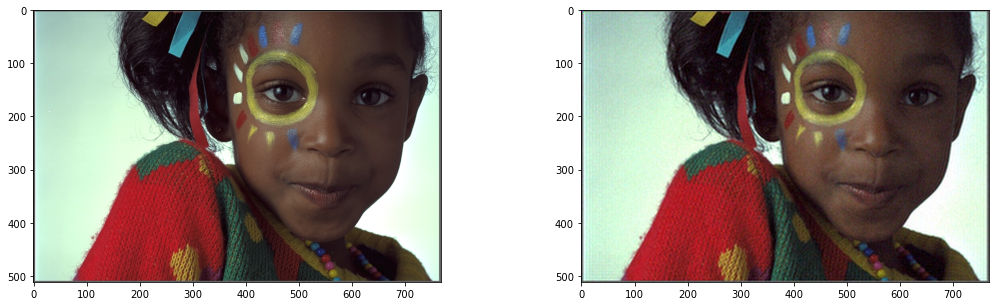

In [8]:
# Constants for Question 1.6.

Kr = 0.299
Kb = 0.114
Kg = 1 - Kr - Kb

# Question 1.6.

# Write your code here! (Add as many cells as you need)

# 1) Get the YcBcR of the image 
ycbcr_img = rgb_to_ycbcr(original, Kr, Kg, Kb)

# 2) Take the DCT of the YcBcR
dct_img = dctim(ycbcr_img)

# 3) Apply a low-pass filter to the spectrum
fcx = original.shape[0] // 3
fcy = original.shape[1] // 3
lopass_image = lopass_spectrum(dct_img, fcx, fcy)

# 4) Quantize the filtered spectrum
bin_indices, limits = quantize(lopass_image, 1500)

# 5) Apply Huffman coding to the quantized spectrum
quantized_list = list(bin_indices)
assembled = huffman_compress(quantized_list)

# 6) Apply huffman decoding
decoded = huffman_decompress(assembled)

# 7) Dequantize image
decoded_np = np.array(decoded)
reconstructed = dequantize(decoded_np, 1500, limits)

# 8) Inflate spectrum
inflated = inflate_spectrum(reconstructed, fcx, fcy, original.shape)

# 9) Reverse DCT
idctim_img = idctim(inflated)

# 10) Reverse YcBcR to RGB
final_img = ycbcr_to_rgb(idctim_img, Kr, Kg, Kb)

# Display final image and error and loss
imshow_side_by_side(original, final_img)
print("Actual compression ratio:", len(assembled) / original.size)
print("Mean Squared Error:", ((original - final_img) ** 2).mean())

----
<span style="background-color: #8C1515; font-weight: bold; color: white;">Question 1.7. Optional—no points assigned.</span>

See if you can find images (from anywhere) where $K_R = K_B = K_G = 1/3$ compresses substantially better, and images where $K_R = 0.299, K_G = 0.587, K_B = 0.114$ compresses sub-stantially better (keeping all other compression parameters the same). Can you suggest any factors that you think might predict which images would compress better?

# Part 2: Subsampling components

It turns out that the human eye is less sensitive to some color details than others. One way to take advantage of this is to downsample particular color components—that is, to save only every $k$-th value in each dimension, for some integer $k$. In image compression, people often say _subsampling_ instead of downsampling.

<br>
<center><img src="img/subsample.png" style="height: 170px;"></center>
<br>

Since this discards some information, we can’t recover exactly the original image. To recover the discarded values at the decompressor, we’ll need to interpolate values somehow. There are a number of ways to do interpolation. The simplest is to just take the color of the nearest pixel that was in the subsampled array, sometimes called _nearest-neighbor interpolation_. (It’s perfectly fine with us if you just implement this.)

<br>
<center><img src="img/subsample-reconstruction.png" style="height: 170px;"></center>
<br>

We could also run more graduated forms of interpolation, like _linear_ or _sinc_ interpolation. Details for those interested are in the handout.

Note that if we subsample _all three_ components, we’ve effectively just reduced the resolution of the image (i.e., downsized the image). The trick here is to subsample only _some_ of the components, but maintain others at full resolution.

_Remark: A challenging aspect of subsampling some components but not others is that the resulting numbers won’t fit neatly into a 3-D array—because each component is of a different (2-D) size. You might need to rework some of your code to account for this, since some functions that previously might have been dealing with 3-D arrays are now dealing with 2-D arrays that aren’t necessarily the same size. Be prepared for this refactoring to take a while. Python snippets (a) and (b) might be helpful._

----
<span style="background-color: #8C1515; font-weight: bold; color: white;">Question 2.1.</span> 

In the cell below, apply the following steps to your sample image:

- Transform the image to YCbCr space.
- Subsample each color component by some factor. (new step)
- Apply all of the steps from Project 1c: DCT, filter, quantize, Huffman.

For _each component separately_, choose and report the highest subsampling factor (fewest samples) for which the recovered image looks, in your subjective judgement, not perceptibly different to the original. This means you’re choosing three factors, one for each of $Y$ , $C_B$ and $C_R$. Your subsampling factors should always be integers. To avoid doubt, 1 is a legitimate factor. You should then be able to apply all your chosen factors simultaneously without perceptibly degrading the image.

As always, display the original and recovered images side by side. Report the compression ratio achieved and the MSE.
Write your chosen subsampling factors, and the compression ratio achieved, in the table on Part 1.

## New Function to Inflate Spectrum
Note that the original `inflate_spectrum` is to be utilized for $3$-D images. As a result, a new version of the function is given here, for use in this part of the project.

In [9]:
def inflated_spectrum(F, fcx, fcy, shape):
    """Returns the zero-padded spectrum of size `shape`, inserting entries
    of `F` into the `[:fcx, :fcy]` entries."""
    spectrum = np.zeros(shape)
    spectrum[:fcx, :fcy] = F.reshape((fcx, fcy))
    return spectrum

We now write code to choose and report the highest subsampling factor for each of $Y, C_B,$ and $C_R$.

## Function for Forward Subsample Compression
A function for forward compression with subsampling.

In [10]:
def forward_subsample_compress(k_values):
    # Subsample each color component by some factor. (new step)
    components = [None] * len(k_values)
    for i in range(len(components)):
        components[i] = orig_components[i][::k_values[i], ::k_values[i]]

    # Setting stationary variables for each component
    bin_sizes = []
    bins = []
    bin_limits = []

    # Looking at each individual component
    for i in range(len(components)):
        # Take DCT of image
        dct_img = dctim(components[i])

        # Do lopass of spectrum
        fcx = components[i].shape[0] // 3
        fcy = components[i].shape[1] // 3
        lopass_image = lopass_spectrum(dct_img, fcx, fcy)

        # Quantize the image
        bin_indices, limits = quantize(lopass_image, 1500)

        # Turn into a list, keep track of respective sizes and limits
        quantized_list = list(bin_indices)
        bin_sizes.append(len(quantized_list))
        bin_limits.append(limits)

        # Creating a list with all the elements
        bins = bins + quantized_list

    # Compress for all pieces and return pertinent data
    assembled = huffman_compress(bins)
    return (assembled, components, bin_sizes, bin_limits)

## Function for Backward Subsample Decompression
A function to perform the opposite above, for easy reutilization.

In [11]:
def backward_subsample_decompress(assembled, orig_components, bin_sizes, bin_limits, components, k_values):
    # Decode using huffman decompress!
    decoded = huffman_decompress(assembled)

    # Separate the three images
    decomps = [None] * len(orig_components)
    total = 0
    for i in range(len(decomps)):
        decomps[i] = decoded[total:total + bin_sizes[i]]
        total += bin_sizes[i]

    # Now trying to go back through the decompression
    new_comps = [None] * len(orig_components)
    for i in range(len(decomps)):
        # Dequantize image
        decoded_np = np.array(decomps[i])
        reconstructed = dequantize(decoded_np, 1500, bin_limits[i])

        fcx = components[i].shape[0] // 3
        fcy = components[i].shape[1] // 3

        # Inflate spectrum
        inflated = inflated_spectrum(reconstructed, fcx, fcy, components[i].shape)

        # Reverse DCT
        idctim_img = idctim(inflated)
        
        # Nearest Neighbors Interpolation
        near_neigh_img = np.kron(idctim_img, np.ones((k_values[i], k_values[i])))
        new_comps[i] = near_neigh_img[:orig_components[i].shape[0], :orig_components[i].shape[1]]

    # Form the edited image and return the final image
    edited_image = np.dstack((new_comps[0], new_comps[1], new_comps[2]))
    final_img = ycbcr_to_rgb(edited_image)
    return final_img

## Function for Comparison of Image
Function used for being able to display the images side by side and print loss and compression ratio.

In [12]:
def compare_two_img(assembled, original, final):
    imshow_side_by_side(original, final)
    print("Actual compression ratio:", len(assembled) / original.size)
    print("Mean Squared Error:", ((original - final) ** 2).mean())

## Finding the Highest Subsampling Factor for $Y, C_B, and C_R$
Utilizing the code from above in order to find optimal!

Results for Y
Actual compression ratio: 0.07466549343532985
Mean Squared Error: 32.61243014865451

Results for Cb
Actual compression ratio: 0.051871405707465276
Mean Squared Error: 36.16527303059896

Results for Cr
Actual compression ratio: 0.05174679226345486
Mean Squared Error: 38.04900868733724



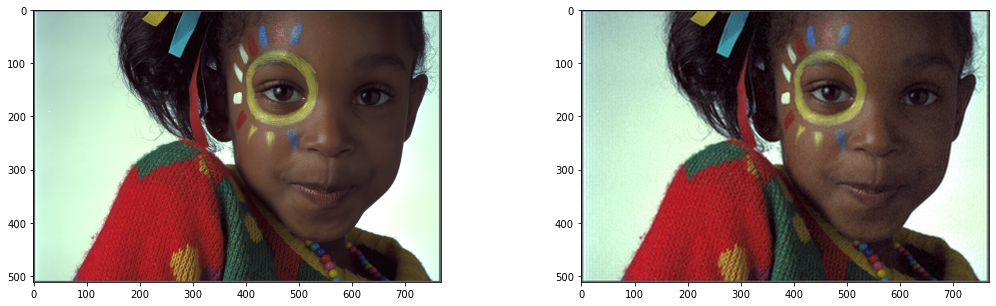

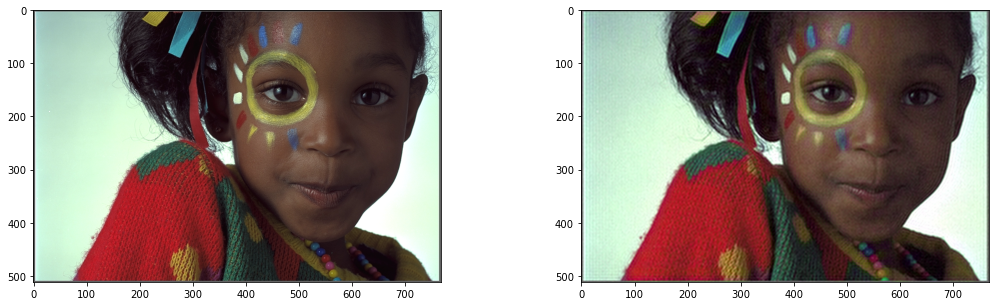

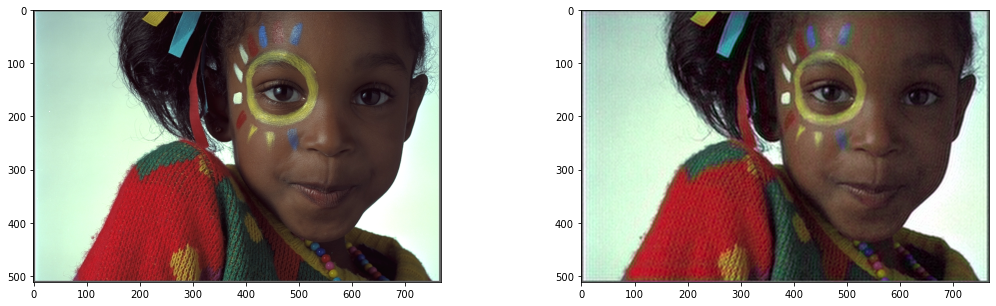

In [13]:
# Question 2.1.

# Defining the original components and original sets of k values
orig_components = create_components(original)
k_array = [[1, 1, 1], [1, 5, 1], [1, 1, 5]]
labels = ['Y', 'Cb', 'Cr']

# Loop through each of the possible sets of values and find optimal!
for i in range(len(orig_components)):
    # Performing compression and decompression
    assembled, components, bin_sizes, bin_limits = forward_subsample_compress(k_array[i])
    final_img = backward_subsample_decompress(assembled, orig_components, bin_sizes, bin_limits, components, k_array[i])

    # Printing results
    print("Results for " + labels[i])
    compare_two_img(assembled, original, final_img)
    print("")

## Looking at Final Image
Using the optimal values found from above, put them all together!

Actual compression ratio: 0.03153567843967014
Mean Squared Error: 38.62643347846137


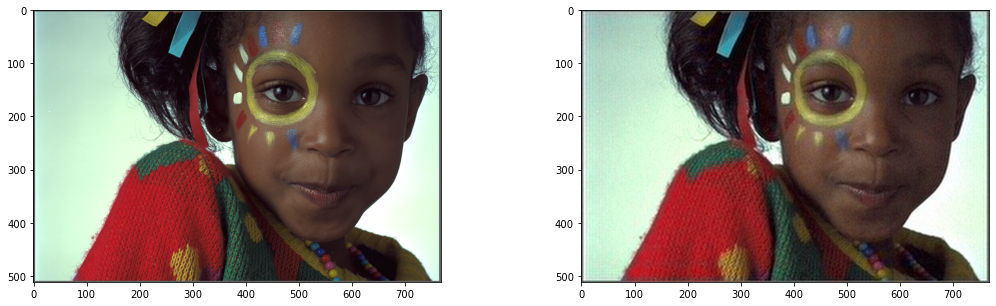

In [14]:
# Question 2.1.

# Defining the original components and original sets of k values
orig_components = create_components(original)
k_array = [1, 5, 5]

# Performing compression and decompression and printing results
assembled, components, bin_sizes, bin_limits = forward_subsample_compress(k_array)
final_img = backward_subsample_decompress(assembled, orig_components, bin_sizes, bin_limits, components, k_array)
compare_two_img(assembled, original, final_img)

----
<span style="background-color: #8C1515; font-weight: bold; color: white;">Question 2.2.</span> 

For each of the three components $(Y, C_B, C_R)$, what happens when you subsample too far? Describe the effect for each component, and show an example in the cell below.

Results for Y
Actual compression ratio: 0.050298055013020836
Mean Squared Error: 78.43480936686198

Results for Cb
Actual compression ratio: 0.045033772786458336
Mean Squared Error: 56.1939951578776

Results for Cr
Actual compression ratio: 0.04423946804470486
Mean Squared Error: 68.88454861111111



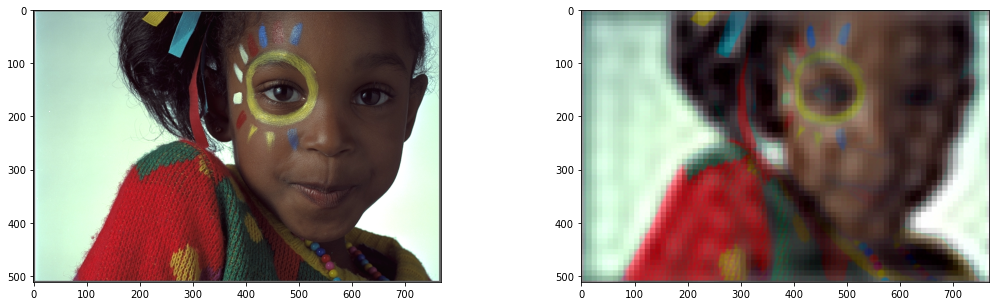

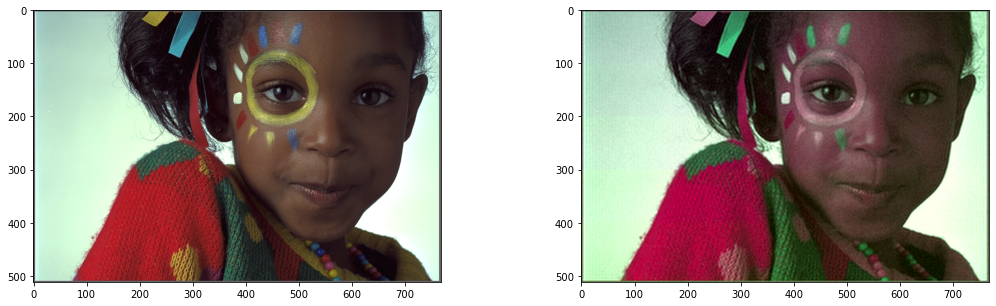

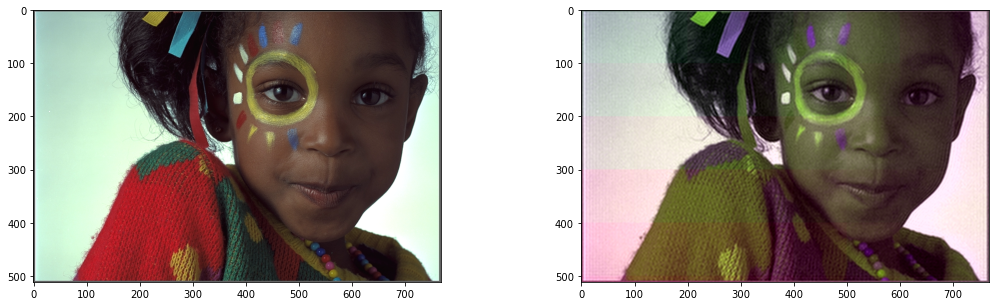

In [15]:
# Question 2.2.

# Defining the original components and original sets of k values
orig_components = create_components(original)
k_array = [[10, 1, 1], [1, 100, 1], [1, 1, 100]]
labels = ['Y', 'Cb', 'Cr']

# Loop through each of the possible sets of values and find optimal!
for i in range(len(orig_components)):
    # Performing compression and decompression
    assembled, components, bin_sizes, bin_limits = forward_subsample_compress(k_array[i])
    final_img = backward_subsample_decompress(assembled, orig_components, bin_sizes, bin_limits, components, k_array[i])

    # Printing results
    print("Results for " + labels[i])
    compare_two_img(assembled, original, final_img)
    print("")

> When the value of the $Y$ component is subsampled too far, the image seems to become a bit blurry and quite pixelated. When the $C_B$ component is subsampled too far, we see that a lot of the darker tones become a bit more red/purple. In addition, a lot of the green colors turn more into blue, someitmes becoming more mint green (such as the background). Finally, when the $C_R$ component is subsampled too far, we see that the main body and face of the girl becomes more green, while a shade of red is layered across the entire picture.

## Analysis questions

<span style="background-color: #8C1515; font-weight: bold; color: white;">Question 3.1.</span> 

In Question 1.6., you (probably) found that the color space transformation by itself seemed to improve the compression ratio, even though this step didn’t involve discarding any information (unlike filtering or subsampling). In fact, the step didn’t even involve lossless compression—the YCbCr array is exactly the same size as the RGB array. Where do you think the savings came from?

_Hint: Try applying your `empirical_entropy()` function from Project 1a to each of the three RGB components of the quantized spectrum, and then to each of the three YCbCr components of the quantized spectrum. Compare this to the empirical entropy you would find under each color model, if you treated each “pixel” in the spectrum (i.e., each group of three numbers relating to a spatial frequency) as a joint symbol._

_Your `empirical_entropy()` function probably only works with 1-D sequences of “hashable” objects. To get it to work with each component (which is each a 2-D array):_

```python
R, G, B = quantized_spectrum.transpose((2, 0, 1)) 
empirical_entropy(R.flatten()) # etc. for G and B, or Y, Cb, Cr
```

_To get it to work on the spectrum’s “pixels”, treating each triple as a single symbol, you might need to make them tuples:_

```python
empirical_entropy([tuple(x) for x in quantized_spectrum.reshape((-1, 3))])
```


In [16]:
# Question 3.1 -- using empircal_entropy function for 
from compressor import empirical_entropy

# Entropy of original RGB Image
bin_indices, limits = quantize(original, 1500)
rgb_entropy = (empirical_entropy([tuple(x) for x in bin_indices.reshape((-1, 3))]))
print("RGB Entropy: ", rgb_entropy)

# YcBcR Entropy
ycbcr_img = rgb_to_ycbcr(original)
bin_indices, limits = quantize(ycbcr_img, 1500)
ycbcr_entropy = (empirical_entropy([tuple(x) for x in bin_indices.reshape((-1, 3))]))
print("YcBcR Entropy: ", ycbcr_entropy)

RGB Entropy:  12.650486819650443
YcBcR Entropy:  12.486453854859223


> From our calculations above, we see that the savings can be attributed to the fact that the RGB entropy is smaller than the YcBcR entropy. When considering the differences from a more conceptual standpoint, YcBcR is simply more aligned with the real-world representation of images. As a result, by converting to YcBcR, we can remove pictorial elements from the original RGB signal that humans aren't able to see at normal viewing <a href="https://kb.portrait.com/help/understanding-the-color-decoder#:~:text=YCbCr%20Video,signal%20and%20two%20chroma%20signals.">distances</a>. Since much of the determination of good parameters is subjective, then YcBcR can act as an effective form of lossless compression.

----
<span style="background-color: #8C1515; font-weight: bold; color: white;">Question 3.2.</span> 

Our lossy image compressor design focused on how the images are perceived by the human eye and how much information can be discarded without affecting the perception. While this is applicable to most cases, there are some scenarios where the image is processed by machines and not by humans—think of self-driving cars viewing the road ahead or an automated diagnosis system for medical imaging. Do you think these ideas are still relevant in such scenarios, and can new ideas be developed specific to these systems? Among the three lossy steps in the process (low-pass filter, quantization, color space subsampling), which ones are the most specific to human perception?

> Overall, I find that the notion of understanding how images are perceived by the human eye is still relevent in such scenarios. More specifically: note that the development of a lot of larger computer vision and machine learning frameworks is driven by human-annotated labels. Thus, even though the image is being processed by machines, a lot of the work under the hood is done by humans to tune the fine parameters. In addition, ideas such as unsupervised learning could be used in helping machines classify certain data without the need for labels, even though humans may still define the pertinent features.

> Among the three lossy steps, I found that low-pass filtering and color space subsampling are the most specific to human perception. I often had times where I needed to take a lot of time in order to fine-tune the specific parameters I inputted, as minor changes could result in drastic repercussions for the perception of the image.

# Reflection

<span style="background-color: #8C1515; font-weight: bold; color: white;">Question R1.</span> Please fill out this Google Form shortly after you finish your project: https://forms.gle/jVr5qFxjQJnzJQdA9

We continue to appreciate your thoughtful and frank reflections!

# <font color="blue"> Submission guidelines</font>

## What and where to submit

- Submit this Jupyter notebook file (.ipynb) to the "**Project 1d**" assignment on Gradescope. Do not submit anything to "Project 1d--extension writeup".
- Don't forget to fill out the reflection form!

## Grade breakdown
The reflection is worth 10 points, the analysis questions are worth 20 points total, coding style is worth 5, and all other questions will total to 65 points.


## Coding style
We expect tidy, properly indented, usefully named variables and functions, avoiding repetition of logic, and with thoughtful decomposition to make your code reasonable and clear. 